# Forereef Spur and Groove Analyser

This notebook analyses spacing of Spurs nd Grooves on coral forereefs. 

Take a bathymetric profile of Spurs and Grooves on a forereef and input the CSV below

In [79]:
# We need the following to be installed:
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d
from scipy.stats import kurtosis
from scipy.signal import find_peaks
from scipy.ndimage.filters import gaussian_filter1d


In [80]:
plt.rcParams.update({'figure.titlesize':40})
plt.rcParams.update({'figure.titleweight':'bold'})
plt.rcParams.update({'figure.constrained_layout.use':True})
plt.rcParams.update({'figure.autolayout':True})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'xtick.labelsize':12})
plt.rcParams.update({'ytick.labelsize':12})
plt.rcParams.update({'grid.alpha':0.8})
plt.rcParams.update({'legend.markerscale':2.0})

In [81]:

def import_profile(SaG_Profile):
    data = pd.read_csv(SaG_Profile, header =0, usecols = (0,1), names = ('distance','elevation'))
    return data

SE4 = import_profile(r'C:\Users\lachl\Desktop\2022 - 1\OTI\xshore_profs\LONG_SE_PROF_2m.csv')
W4 = import_profile(r'C:\Users\lachl\Desktop\2022 - 1\OTI\xshore_profs\west_2m.csv')


all_data = ['SE4, W4']

In [82]:
def odd_length(data):
    num = len(data)
    if (num % 2) == 0:
        data = data.drop([len(data)-1], axis=0, inplace=True)
        print ('The data set length is now odd')
    else:
        print ('The data set length is odd')  
        
        
#def mean_elev(data):
    

    
#get_peak_positions(E4)
    
for data in all_data:    
    odd_length(data)
#mean_elev(E4)

The data set length is odd


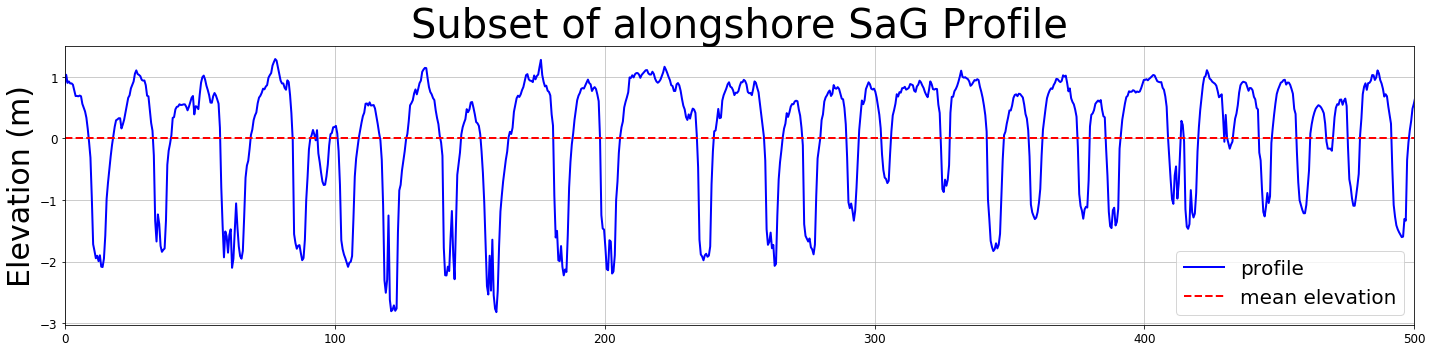

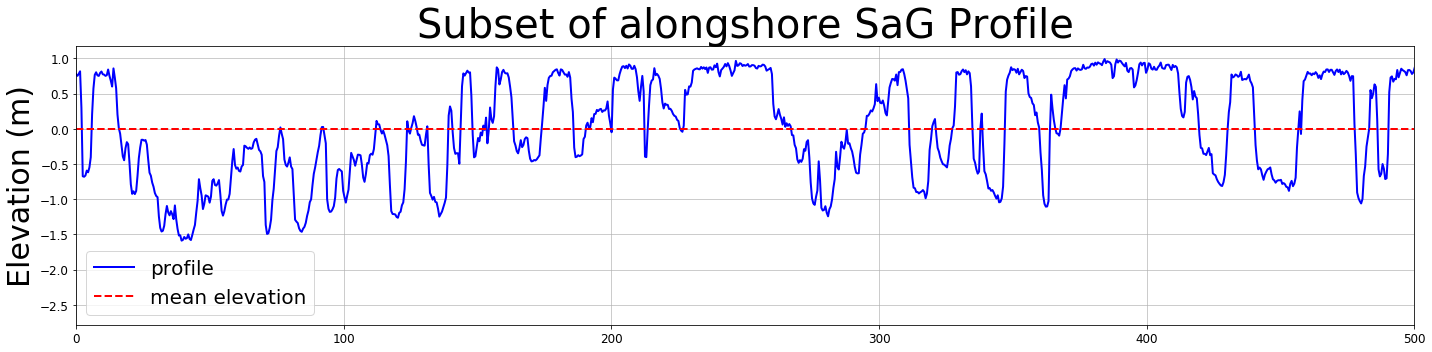

In [83]:
def plot_profile(data, detrend = False):
 

    x = data.distance        
    y = data.elevation
    y2 = np.linspace(np.mean(data.elevation), np.mean(data.elevation), len(data))
    
    if detrend:
        data['detrend'] = signal.detrend(data.elevation, type == 'constant')
        y = data.detrend
        y2 = np.linspace(np.mean(data.detrend), np.mean(data.detrend), len(data))

    peaks = find_peaks(y, y2, threshold =1, distance = 20)
    height = peaks[1]['peak_heights']
    peak_pos = x[peaks[0]]
    
    

    

    fig, ax1 = plt.subplots(figsize=(20,5))
    ax1.set_xlim([0,500]) 
    plt.title('Subset of alongshore SaG Profile', fontsize = 40)
    plt.ylabel('Elevation (m)', fontsize = 30)
    ax1.plot(x, y, linewidth=2, color = 'blue', label = 'profile')
    ax1.plot(x, y2, linewidth=2, color = 'red', label = 'mean elevation', linestyle = 'dashed')
    ax1.scatter(peak_pos,height)
    ax1.legend(fontsize = 20, loc = 'best')
    plt.grid()
    return 

plot_profile(SE4, detrend = True)
plot_profile(W4, detrend = True)

## Zero-crossing method to dermine λsag

In [84]:
## Coming soon

## Statistical methods fo elevation distribution

These statistcal methods have been taken from Duvall et al., (2019)


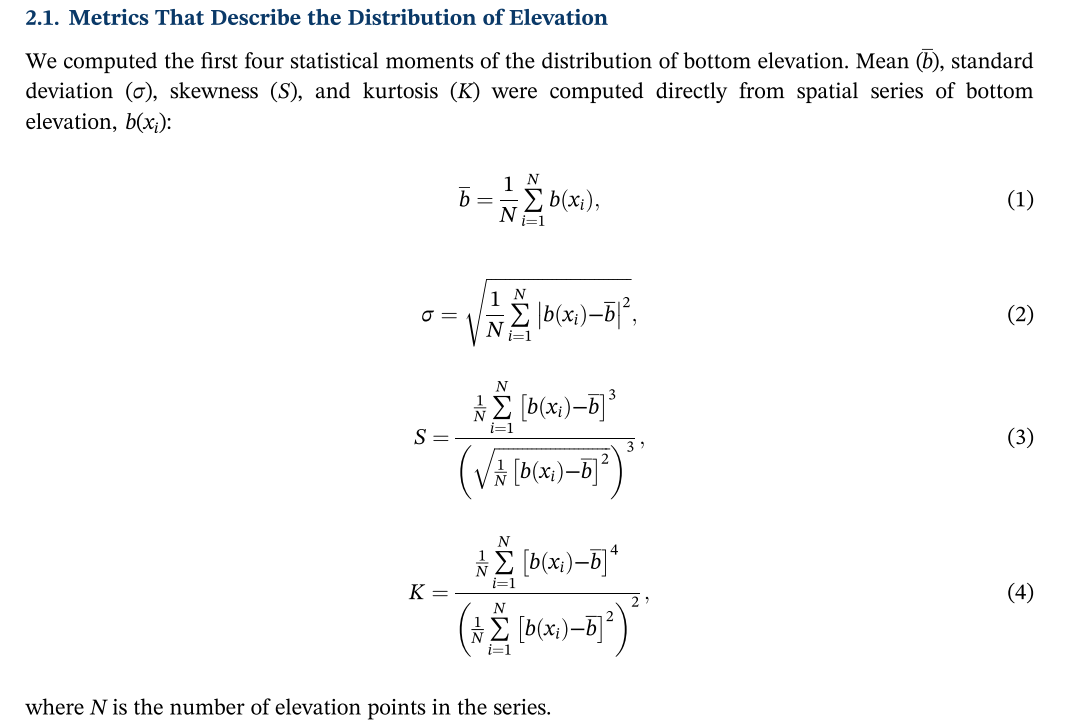

In [89]:
def get_stats(data):
    N = len(data)
    b = data.elevation
    b_= np.mean(b) ## Just use numpy mean
    
    delta_b = np.max(b) - np.min(b)
    delta_x = np.max(data.distance) - np.min(data.distance)

    R = (1/(N-1) * np.sqrt(1+((delta_b/0.5)**2)))
    
    
    sigma = statistics.stdev(b,b_)
    
    k_t = kurtosis(b)
  
    
    print ('mean elevation = ' +str(b_))
    print ('Standard Deviation = ' +str(sigma))
    print ('Skewness = ' +str(sigma))
    print('Kurtosis = ' +str(k_t))
    print('Rugosity = ' +str(R))
    
    
    return

In [90]:
print('Stats for SE4: ')
get_stats(SE4)



Stats for SE4: 
mean elevation = -4.971441283124128
Standard Deviation = 0.9367813324689774
Skewness = 0.9367813324689774
Kurtosis = -0.4153728655125297
Rugosity = 0.0038406398072089796


In [91]:
print('Stats for W4: ')
get_stats(W4)

Stats for W4: 
mean elevation = -2.1193483835617095
Standard Deviation = 0.7975593126138661
Skewness = 0.7975593126138661
Kurtosis = -0.6295297744380384
Rugosity = 0.0038909021139387654


## We can apply sepctral analysis to determine λsag and groove depths

In [92]:
def get_ampspec(trimdata):
    dt = 0.001
    hanning = True
    plot = True
    
    # Detrend the time series
    detrend = signal.detrend(trimdata.elevation, type == 'constant')
    n = len(detrend)
    if hanning:
        detrend = detrend*np.hanning(n)
        

    xn = np.fft.fft(detrend)

    if hanning:

        xn = xn *np.sqrt(8./3.)

    conj = xn.conjugate()
    pxx = dt*(xn*conj)/n
    
    paa = np.sqrt(xn*conj)/n
    pxx = dt*(xn*conj)/n
    
    nf = int(np.fix((n/2.)+1))

    ampspec = (2.0*paa[0:nf]).real # amplitude spectrum

    maxf = 1/(2*dt)
    df = 1/(n*dt)
    freq = np.arange(0,maxf,df)
    period = 1/(freq+1.e-100)
    

    
    return freq, ampspec


freq, ampspec = get_ampspec(SE4) 

C:\Users\lachl\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.canvas.print_figure(bytes_io, **kw)


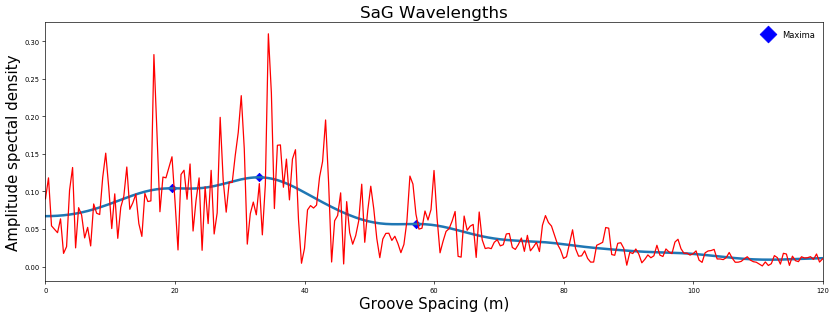

In [95]:
east_df=pd.DataFrame()
east_df['ampspec'] = ampspec
east_df['freq'] = freq

fig = plt.figure(figsize=(17,6), dpi=60) 
ax = plt.gca()

x = east_df['freq']

##Apply filter to smooth spectrum data
ysmoothed = gaussian_filter1d(ampspec, sigma=10)
plt.plot(x, ysmoothed, linewidth = 3)




#Find peaks
peaks = find_peaks(ysmoothed, height = 0, threshold = 0, distance = 1)
height = peaks[1]['peak_heights'] #list of the heights of the peaks
peak_pos = x[peaks[0]] #list of the peaks positions


##Plot amplitude spectrum:
plt.plot(x, ampspec, linestyle = 'solid', 
         c='r')

##Plot peaks as scatter:
plt.scatter(peak_pos, height, color = 'b', s = 50, marker = 'D', label = ('Maxima'))


##Label plot and legend:
plt.title('SaG Wavelengths', fontsize = 20)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(-0.01,120)
#plt.ylim(0,0.5)
ax.set_ylabel('Amplitude spectal density',fontsize=18)
ax.set_xlabel('Groove Spacing (m)',fontsize=18
             )
plt.legend(loc=0, frameon=False)


plt.show()